In [1]:
# pip install defaltdict

In [2]:
from enum import Enum
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import matplotlib.cm as cm
import gym
from gym.envs.registration import register
register(id="FrozenLakeEasy-v1", entry_point="gym.envs.toy_text:FrozenLakeEnv",
         kwargs={"is_slippery": False})

In [3]:
def visualize_v_grid(v_grid, env):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Convert V_grid to numpy array for easier manipulation
    v_array = np.array(v_grid)
    
    # Create a mask for zero values (non-accessible states)
    zero_mask = v_array == 0.0
    
    # Create a custom colormap
    cmap = plt.cm.YlGn.copy()
    cmap.set_bad(color='gray')
    
    # Create heatmap
    v_array_masked = np.ma.masked_where(zero_mask, v_array)
    im = ax.imshow(v_array_masked, cmap=cmap)
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")
    
    # Add text annotations
    for i in range(v_array.shape[0]):
        for j in range(v_array.shape[1]):
            if zero_mask[i, j]:
                text = ax.text(j, i, 'X', ha="center", va="center", color="white", fontweight='bold')
            else:
                text = ax.text(j, i, f'{v_array[i, j]:.3f}',
                               ha="center", va="center", color="black")
    
    # Set tick labels
    ax.set_xticks(np.arange(v_array.shape[1]))
    ax.set_yticks(np.arange(v_array.shape[0]))
    ax.set_xticklabels(range(v_array.shape[1]))
    ax.set_yticklabels(range(v_array.shape[0]))
    
    # Add grid
    ax.set_xticks(np.arange(-0.5, v_array.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, v_array.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", va="center")
    
    # Add title
    ax.set_title("Value Function Heatmap")
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [4]:
def make_hashable(s):
    if isinstance(s, (tuple, list)):
        return tuple((make_hashable(e) for e in s))
    elif isinstance(s, dict):
        return tuple(sorted((k, make_hashable(v)) for k, v in s.items()))
    else:
        return s

In [5]:
class ELAgent():

    def __init__(self, epsilon):
        self.Q = {}
        self.epsilon = epsilon
        self.reward_log = []

    def policy(self, s, actions):
        if np.random.random() < self.epsilon:
            return np.random.randint(len(actions))
        else:
            # print("State Type: ", type(s))
            # print("State: ", s)
            if s in self.Q and sum(self.Q[s]) != 0:
                return np.argmax(self.Q[s])
            else:
                return np.random.randint(len(actions))

    def init_log(self):
        self.reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self, interval=50, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print("At Episode {} average reward is {} (+/-{}).".format(
                   episode, mean, std))
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds,
                             alpha=0.1, color="g")
            plt.plot(indices, means, "o-", color="g",
                     label="Rewards for each {} episode".format(interval))
            plt.legend(loc="best")
            plt.show()

In [6]:
def show_q_value(Q):
    """
    Show Q-values for FrozenLake-v0.
    To show each action's evaluation,
    a state is shown as 3 x 3 matrix like following.

    +---+---+---+
    |   | u |   |  u: up value
    | l | m | r |  l: left value, r: right value, m: mean value
    |   | d |   |  d: down value
    +---+---+---+
    """
    env = gym.make("FrozenLake-v1")
    nrow = env.unwrapped.nrow
    ncol = env.unwrapped.ncol
    state_size = 3
    q_nrow = nrow * state_size
    q_ncol = ncol * state_size
    reward_map = np.zeros((q_nrow, q_ncol))

    for r in range(nrow):
        for c in range(ncol):
            s = r * ncol + c
            state_exist = False
            if isinstance(Q, dict) and s in Q:
                state_exist = True
            elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
                state_exist = True

            if state_exist:
                # At the display map, the vertical index is reversed.
                _r = 1 + (nrow - 1 - r) * state_size
                _c = 1 + c * state_size
                reward_map[_r][_c - 1] = Q[s][0]  # LEFT = 0
                reward_map[_r - 1][_c] = Q[s][1]  # DOWN = 1
                reward_map[_r][_c + 1] = Q[s][2]  # RIGHT = 2
                reward_map[_r + 1][_c] = Q[s][3]  # UP = 3
                reward_map[_r][_c] = np.mean(Q[s])  # Center

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(reward_map, cmap=cm.RdYlGn, interpolation="bilinear",
               vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
    ax.set_xlim(-0.5, q_ncol - 0.5)
    ax.set_ylim(-0.5, q_nrow - 0.5)
    ax.set_xticks(np.arange(-0.5, q_ncol, state_size))
    ax.set_yticks(np.arange(-0.5, q_nrow, state_size))
    ax.set_xticklabels(range(ncol + 1))
    ax.set_yticklabels(range(nrow + 1))
    ax.grid(which="both")
    plt.show()

In [7]:
class MonteCarloAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        #　defaultditctを使った初期化をすることで，Q値が存在しない場合に0で初期化される
        # 今までのマルコフ決定過程のように全てのsとaに対してする必要がないため，メモリ効率が良い
        self.Q = defaultdict(lambda: [0] * len(actions))
        #　行動回数
        N = defaultdict(lambda: [0] * len(actions))

        for e in range(episode_count):
            s = env.reset()
            s = s[0]
            done = False
            # Play until the end of episode.
            experience = []

            #全てのエピソードが終了するまで繰り返す
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                # print(env.step(a))
                n_state, reward, terminated, truncated, info = env.step(a)
                done = terminated or truncated
                experience.append({"state": s, "action": a, "reward": reward})
                s = n_state
            else:
                self.log(reward)

            # ここの部分がMonte Carlo法の本質
            # 1エピソード終了後に，そのエピソードでの報酬をもとにQ値を更新する
            for i, x in enumerate(experience):
                s, a = x["state"], x["action"]

                # Calculate discounted future reward of s.
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += math.pow(gamma,t) * experience[j]["reward"]
                    t += 1

                N[s][a] += 1
                alpha = 1 / N[s][a]
                self.Q[s][a] = self.Q[s][a] + alpha * (G - self.Q[s][a])
            


            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)

In [8]:
def train():
    agent = MonteCarloAgent(epsilon = 0.1)
    env = gym.make("FrozenLakeEasy-v1")
    agent.learn(env, episode_count=5000)
    show_q_value(agent.Q)
    agent.show_reward_log()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


At Episode 50 average reward is 0.0 (+/-0.0).
At Episode 100 average reward is 0.0 (+/-0.0).
At Episode 150 average reward is 0.0 (+/-0.0).
At Episode 200 average reward is 0.58 (+/-0.494).
At Episode 250 average reward is 0.92 (+/-0.271).
At Episode 300 average reward is 0.92 (+/-0.271).
At Episode 350 average reward is 0.88 (+/-0.325).
At Episode 400 average reward is 0.88 (+/-0.325).
At Episode 450 average reward is 0.88 (+/-0.325).
At Episode 500 average reward is 0.96 (+/-0.196).
At Episode 550 average reward is 0.94 (+/-0.237).
At Episode 600 average reward is 0.92 (+/-0.271).
At Episode 650 average reward is 0.98 (+/-0.14).
At Episode 700 average reward is 0.9 (+/-0.3).
At Episode 750 average reward is 0.86 (+/-0.347).
At Episode 800 average reward is 0.88 (+/-0.325).
At Episode 850 average reward is 0.9 (+/-0.3).
At Episode 900 average reward is 0.92 (+/-0.271).
At Episode 950 average reward is 0.96 (+/-0.196).
At Episode 1000 average reward is 0.86 (+/-0.347).
At Episode 1050 

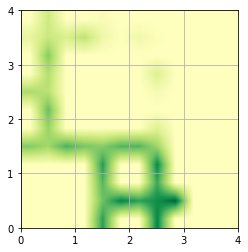

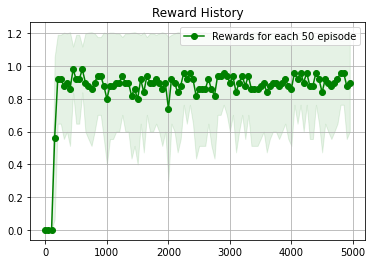

In [9]:
if __name__ == "__main__":
    train()